In [1]:
!pip install workalendar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 4.4 MB/s eta 0:00:00


# Importing Libraries

In [2]:
import datetime
import os
from joblib import Parallel, delayed
from time import sleep, time
import itertools
import holidays
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import statsmodels
import statsmodels.tsa.api as sm
import tensorflow as tf
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout,Conv1D
from matplotlib import rcParams  # Used to set default paremeters
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf, quarter_plot
from workalendar.europe import UnitedKingdom

# Setting Plotting Environment

In [3]:
sns.set_style("whitegrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_font_size = 13
medium_font_size = 14
large_font_size = 17

#Changing the font size of dfault,axis,legends and titles
matplotlib.rc("font", size=small_font_size)  
matplotlib.rc("axes", titlesize=small_font_size)  
matplotlib.rc("axes", labelsize=medium_font_size)  
matplotlib.rc("xtick", labelsize=small_font_size)  
matplotlib.rc("ytick", labelsize=small_font_size)  
matplotlib.rc("legend", fontsize=small_font_size)  
matplotlib.rc("axes", titlesize=large_font_size)  

# Acessing and uploading data

Load data is accessed from [the National Grid](https://data.nationalgrideso.com) comprising of electricity demand between 2009 and 2022. 

In [4]:
from google.colab import files
uploaded = files.upload()

Saving historic_demand_2009_2023.csv to historic_demand_2009_2023.csv


In [5]:
data_frame = pd.read_csv("/content/historic_demand_2009_2023.csv", index_col=0)

# Changing words to lower case and drop id (row number)
data_frame.columns = data_frame.columns.str.lower()

In [6]:
data_frame.head(n=7)

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,is_holiday
0,2009-01-01,1,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,NaN,NaN,1
1,2009-01-01,2,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,NaN,NaN,1
2,2009-01-01,3,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,NaN,NaN,1
3,2009-01-01,4,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,NaN,NaN,1
4,2009-01-01,5,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,NaN,NaN,1
5,2009-01-01,6,35408,37135,31604,43,1403,0,0,0,967,1754,0,0,-160,0,0,NaN,NaN,1
6,2009-01-01,7,34322,36844,30486,43,1403,0,0,0,1762,1754,0,0,-160,0,0,NaN,NaN,1


In [7]:
data_frame.describe()

,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,is_holiday
count,248832.000000,248832.000000,248832.000000,248832.000000,248832.000000,248832.000000,248832.000000,248832.000000,248832.000000,248832.000000,248832.000000,248832.000000,248832.000000,248832.000000,248832.000000,248832.000000,73536.000000,73536.000000,248832.000000
mean,24.500225,31874.318150,33260.648739,28994.951481,1206.813742,4190.309285,789.320425,7710.477238,7.468027,321.632845,920.583092,7.342110,541.702675,-107.337340,-24.603226,148.314325,162.112326,-70.355826,0.022569
std,13.853817,7773.401229,7704.377869,7047.777021,923.761138,1921.209337,1586.175877,5485.819638,41.402477,545.214243,1094.462329,302.444107,507.878115,222.298607,250.845425,385.880476,472.836774,342.489494,0.148527
min,1.000000,13367.000000,0.000000,0.000000,0.000000,1403.000000,0.000000,0.000000,-24.000000,0.000000,-2056.000000,-1030.000000,-1215.000000,-505.000000,-585.000000,-1022.000000,-1455.000000,-1028.000000,0.000000
25%,12.750000,25662.750000,27279.000000,23337.000000,517.000000,2085.000000,0.000000,1802.000000,0.000000,8.000000,206.000000,0.000000,0.000000,-251.000000,-126.000000,0.000000,0.000000,0.000000,0.000000
50%,24.500000,31323.000000,32521.000000,28471.000000,966.000000,4136.000000,0.000000,9273.000000,0.000000,12.000000,1251.000000,0.000000,765.000000,-119.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,36.250000,37596.000000,38745.000000,34225.000000,1641.000000,6192.000000,716.000000,13080.000000,0.000000,474.000000,1900.000000,0.000000,994.000000,45.000000,6.000000,0.000000,65.250000,0.000000,0.000000
max,50.000000,59095.000000,60147.000000,53325.000000,5354.000000,6574.000000,9680.000000,13861.000000,893.000000,2019.000000,2066.000000,1016.000000,1143.000000,499.000000,504.000000,1033.000000,1401.000000,1002.000000,1.000000


# **Data Pre-processing**

In [8]:
# Sort values by date
data_frame.sort_values(
    by=["settlement_date", "settlement_period"], inplace=True, ignore_index=True
)

data_frame.isna().any()

settlement_date              False
settlement_period            False
nd                           False
tsd                          False
england_wales_demand         False
embedded_wind_generation     False
embedded_wind_capacity       False
embedded_solar_generation    False
embedded_solar_capacity      False
non_bm_stor                  False
pump_storage_pumping         False
ifa_flow                     False
ifa2_flow                    False
britned_flow                 False
moyle_flow                   False
east_west_flow               False
nemo_flow                    False
nsl_flow                      True
eleclink_flow                 True
is_holiday                   False
dtype: bool

In [9]:
pd.concat(
    [
        data_frame["nsl_flow"].isna().value_counts().to_frame(),
        data_frame["eleclink_flow"].isna().value_counts().to_frame(),
    ],
    axis=1,
    ignore_index=True,
).rename(columns={0: "nsl_flow", 1: "eleclink_flow"})

,nsl_flow,eleclink_flow
True,175296,175296
False,73536,73536


It seems that both features have the same number of `nan` values. Let's have a look at that the dataframe containing the `nan` value:

In [10]:
data_frame.loc[(data_frame["eleclink_flow"].isna()) | (data_frame["nsl_flow"].isna()), :]

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,is_holiday
0,2009-01-01,1,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,NaN,NaN,1
1,2009-01-01,2,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,NaN,NaN,1
2,2009-01-01,3,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,NaN,NaN,1
3,2009-01-01,4,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,NaN,NaN,1
4,2009-01-01,5,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175291,2018-12-31,44,26826,28428,25195,2734,5918,0,13052,0,13,1960,0,777,-454,-535,0,NaN,NaN,0
175292,2018-12-31,45,25660,27542,24145,2730,5918,0,13052,0,23,1182,0,-268,-455,-536,0,NaN,NaN,0
175293,2018-12-31,46,25047,26971,23496,2726,5918,0,13052,0,36,1157,0,-297,-455,-536,0,NaN,NaN,0
175294,2018-12-31,47,24188,26224,22683,2673,5918,0,13052,0,49,1546,0,-467,-454,-466,0,NaN,NaN,0


In [11]:
data_frame.drop(columns=["nsl_flow", "eleclink_flow"], axis=1, inplace=True)

# Drop rows where settlement_period value is greater than 48
data_frame.drop(index=data_frame[data_frame["settlement_period"] > 48].index, inplace=True)

data_frame.reset_index(drop=True, inplace=True)

Conidering holdays of bank.

In [15]:
# Compare England's and Wales' bank holiday
bank_holiday_england = holidays.UK(
    subdiv="England", years=range(2009, 2024), observed=True
).items()
bank_holiday_wales = holidays.UK(
    subdiv="Wales", years=range(2009, 2024), observed=True
).items()

print(bank_holiday_england == bank_holiday_wales)

True


In [16]:
# Create empty lists to store data
names_of_holidays = []
dates_of_holidays = []
names_of_holidays_observed = []
dates_of_holidays_observed = []

for date, name in sorted(bank_holiday_england):
    dates_of_holidays.append(date)
    names_of_holidays.append(name)
    # Pop the previous value as observed bank holidays takes place later
    if "Observed" in name:
        dates_of_holidays_observed.pop()
        names_of_holidays_observed.pop()
    names_of_holidays_observed.append(name)
    dates_of_holidays_observed.append(np.datetime64(date))

dates_of_holidays_observed[:5]

[numpy.datetime64('2009-01-01'),
 numpy.datetime64('2009-04-10'),
 numpy.datetime64('2009-04-13'),
 numpy.datetime64('2009-05-04'),
 numpy.datetime64('2009-05-25')]

In [17]:
data_frame["is_holiday"] = data_frame["settlement_date"].apply(
    lambda x: pd.to_datetime(x) in dates_of_holidays_observed
)

data_frame["is_holiday"] = data_frame["is_holiday"].astype(int)

data_frame[data_frame["is_holiday"] == 1].sample(7)

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
192838,2020-01-01,45,27187,28451,25315,2502,6465,0,13080,0,9,1430,0,856,81,504,-655,1
161984,2018-03-30,5,27052,29309,24938,1463,5978,0,13052,0,1757,1493,0,1000,228,348,0,1
163849,2018-05-07,46,26642,27156,24023,789,5859,0,13052,0,14,1995,0,342,92,0,0,1
94609,2014-05-26,14,22709,24014,20100,259,2718,345,4755,0,673,107,0,414,-79,-53,0,1
109597,2015-04-03,28,35189,35946,31517,2059,3989,1390,8471,0,9,998,0,975,-82,-166,0,1
4772,2009-04-10,23,36159,37023,32500,721,1613,0,0,0,2,2003,0,0,-362,0,0,1
4913,2009-04-13,20,32758,33390,29274,192,1613,0,0,0,8,1503,0,0,-124,0,0,1


Bank holidays visualization along the electricity demand

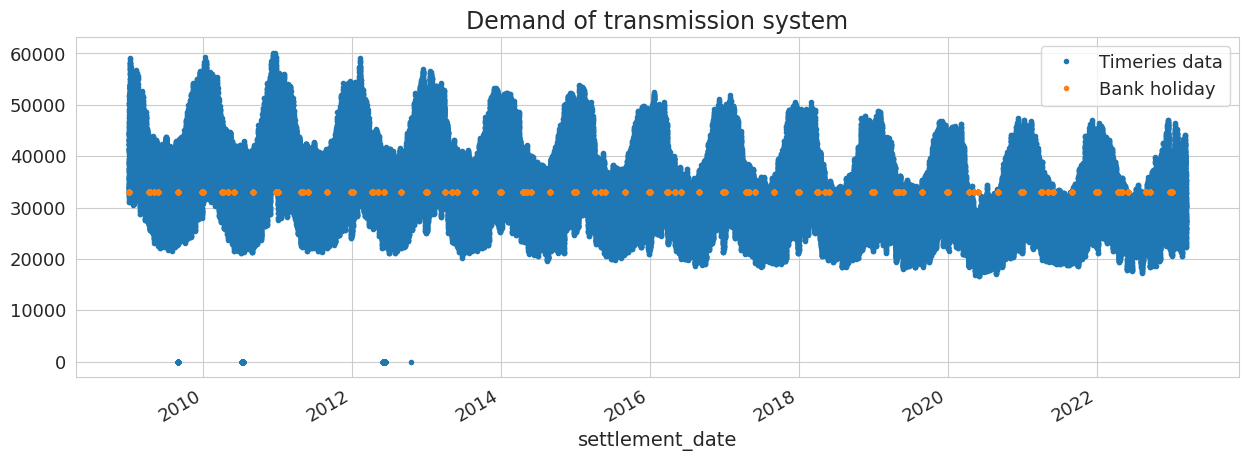

In [18]:
# Set date as the index and turn into datetime type
df_plot = data_frame.copy()
df_plot = df_plot.set_index("settlement_date")
df_plot.index = pd.to_datetime(df_plot.index)

fig, ax = plt.subplots(figsize=(15, 5))
df_plot["tsd"].plot(
    style=".", ax=ax, title="Demand of transmission system", label="Timeries data"
)
(df_plot.query("is_holiday == 1")["is_holiday"] * 33000).plot(
    style=".", ax=ax, label="Bank holiday"
)
ax.legend();

Analyzing and visualizing if any outliers present in the dataset 


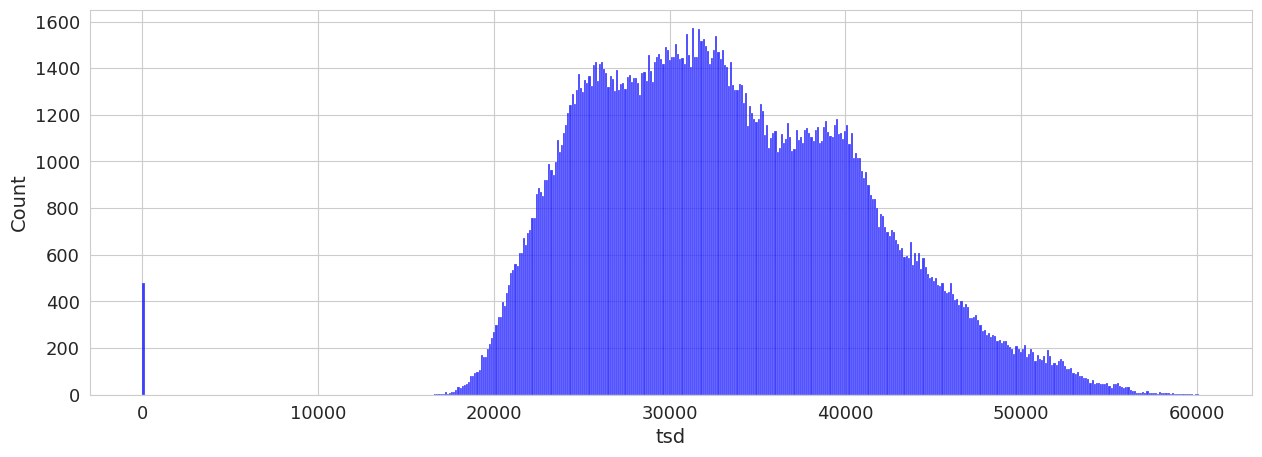

In [19]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.histplot(data=data_frame, x="tsd", bins=500, ax=ax, color="blue");

In [20]:
empty_days = data_frame.loc[data_frame["tsd"] == 0.0, "settlement_date"].unique().tolist()

empty_days_index = []

for day in empty_days:
    empty_days_index.append(data_frame[data_frame["settlement_date"] == day].index.tolist())

empty_days_index = [item for sublist in empty_days_index for item in sublist]

data_frame.drop(index=empty_days_index, inplace=True)
data_frame.reset_index(drop=True, inplace=True)

## **Features generation**
The initial stage of feature creation involves modifying the date format to incorporate hourly values. The settlement_period values indicate the number of samples taken within a day. Considering there are 48 samples per day, each sample corresponds to a duration of 30 minutes within the day.

In [21]:
# Apply a lambda function to convert the settlement period to hours. 
#The settlement period starts at 0, which corresponds to 00:00:00, 
#and each subsequent settlement period adds 30 minutes. 
#The last settlement period, 48, corresponds to 23:30:00.
data_frame["period_hour"] = (data_frame["settlement_period"]).apply(
    lambda x: str(datetime.timedelta(hours=(x - 1) * 0.5))
)

data_frame.loc[data_frame["period_hour"] == "1 day, 0:00:00", "period_hour"] = "0:00:00"

# Move the new column
column_to_move = data_frame.pop("period_hour")
data_frame.insert(2, "period_hour", column_to_move)

data_frame.sample(n=7)

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
218497,2021-07-04,28,13:30:00,24536,25749,22197,908,6527,4970,13080,0,5,2004,991,1003,-457,-250,999,0
44361,2011-07-20,16,7:30:00,35601,36491,32516,156,1828,12,480,0,8,94,0,-319,-63,0,0,0
40327,2011-04-27,14,6:30:00,30057,31648,26591,315,1761,2,151,0,11,-371,0,-605,-104,0,0,0
64134,2012-09-12,15,7:00:00,33924,36054,30792,597,2085,27,1873,0,13,-343,0,-624,-123,-527,0,0
4675,2009-04-08,22,10:30:00,41195,41899,37400,1202,1613,0,0,0,9,1469,0,0,-195,0,0,0
100685,2014-10-14,42,20:30:00,39965,41175,36452,625,4127,0,5463,0,16,998,0,993,-214,-480,0,0
175982,2019-01-30,35,17:00:00,46337,48020,41862,535,6135,0,13052,0,14,1998,0,963,-454,-535,0,0



As observed, a newly added column named "period_hour" contains the hour at which the measurement of electricity demand was recorded. It is now possible to merge this information with the actual date using the following approach:

In [22]:
data_frame["settlement_date"] = pd.to_datetime(
    (data_frame["settlement_date"] + " " + data_frame["period_hour"])
)

data_frame.sample(n=5)

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
14230,2009-10-26 12:00:00,25,12:00:00,42056,44249,38046,481,1737,0,0,0,4,-1235,0,0,-354,0,0,0
144253,2017-04-09 15:30:00,32,15:30:00,21238,21868,19004,2666,5108,5440,11750,0,2,1701,0,548,-25,-103,0,0
211967,2021-02-18 11:30:00,24,11:30:00,33250,33998,30835,3022,6527,3100,13080,0,12,1952,-136,204,130,0,799,0
112295,2015-06-13 18:30:00,38,18:30:00,31694,32415,28834,597,3889,687,8666,0,10,1997,0,1000,201,-211,0,0
196226,2020-03-27 12:00:00,25,12:00:00,24200,25674,21281,1594,6559,8640,13080,0,8,1801,0,903,-333,-533,903,0


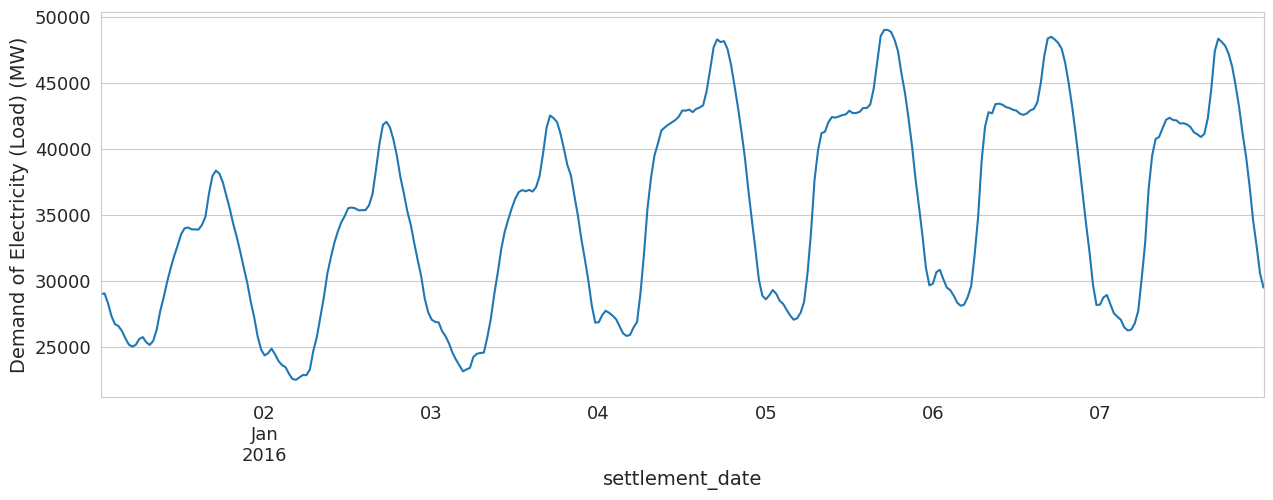

In [23]:
data_frame.set_index("settlement_date", inplace=True)
data_frame.sort_index(inplace=True)

data_frame.loc[(data_frame.index > "01-01-2016") & (data_frame.index < "01-08-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Demand of Electricity (Load) (MW)"
);

In [26]:
def features_generation(data_frame):

    data_frame = data_frame.copy()
    data_frame["Month_day"] = data_frame.index.day
    data_frame["day_of_week"] = data_frame.index.day_of_week
    data_frame["day_of_year"] = data_frame.index.day_of_year
    data_frame["quarter"] = data_frame.index.quarter
    data_frame["month"] = data_frame.index.month
    data_frame["year"] = data_frame.index.year
    data_frame["week_of_year"] = data_frame.index.isocalendar().week.astype("int64")
    return data_frame

#We choose the number 364 instead of 365 because 364 is divisible by 4, 
#allowing us to avoid the need for mapping specific days.

def add_lags(data_frame):
    targetted_mapping = data_frame["tsd"].to_dict()
    data_frame["lag1"] = (data_frame.index - pd.Timedelta("364 Days")).map(targetted_mapping)
    data_frame["lag2"] = (data_frame.index - pd.Timedelta("728 Days")).map(targetted_mapping)
    data_frame["lag3"] = (data_frame.index - pd.Timedelta("1092 Days")).map(targetted_mapping)
    return data_frame

In [27]:
data_frame = features_generation(data_frame)
data_frame = add_lags(data_frame)

data_frame.sample(n=5)

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,Month_day,day_of_week,day_of_year,quarter,month,year,week_of_year,lag1,lag2,lag3
settlement_date,,,,,,,,,,,,,,,,,,,,,
2020-10-04 10:00:00,21,10:00:00,29111,29620,26735,1853,6527,1330,13080,0,...,4,6,278,4,10,2020,40,26874.0,27614.0,29337.0
2010-04-15 21:00:00,43,21:00:00,40532,42674,36760,770,1883,0,19,0,...,15,3,105,2,4,2010,15,40077.0,NaN,NaN
2019-11-05 09:30:00,20,9:30:00,36525,37137,33343,2163,6231,1090,13080,0,...,5,1,309,4,11,2019,45,37129.0,40705.0,44051.0
2019-10-23 22:30:00,46,22:30:00,27854,28398,26063,2132,6231,0,13080,0,...,23,2,296,4,10,2019,43,28727.0,31075.0,32424.0
2013-10-09 00:00:00,1,0:00:00,25446,27835,23214,481,2337,0,3032,0,...,9,2,282,4,10,2013,41,28837.0,27825.0,29685.0


## **Feature understanding**

In this section, we will examine the distribution of electricity demand in relation to various features, such as the hour, month, or year. This analysis provides valuable insights into the seasonal patterns within the time series data.

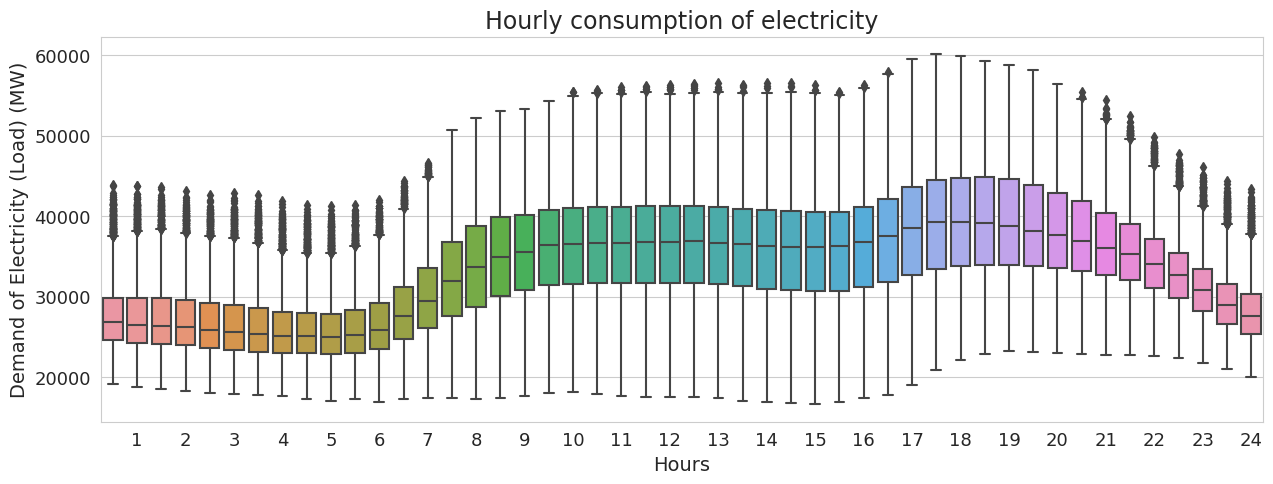

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="settlement_period", y="tsd", data=data_frame)
ax.set_xticks(range(1, 49, 2))
ax.set_xticklabels(range(1, 25))
ax.set_xlabel("Hours")
ax.set_ylabel("Demand of Electricity (Load) (MW)")
ax.set_title("Hourly consumption of electricity");

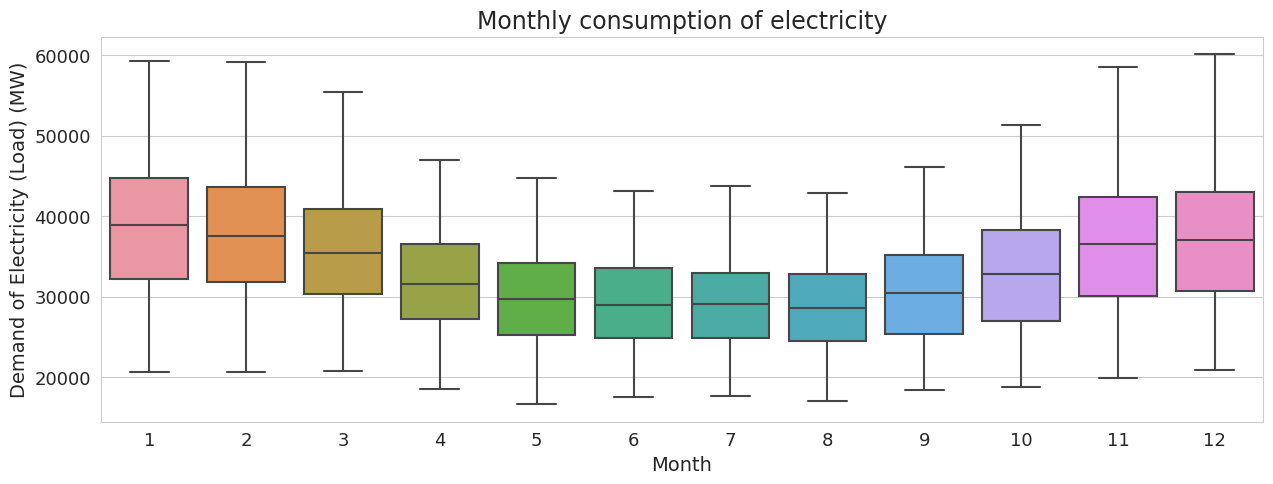

In [29]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="month", y="tsd", data=data_frame)
ax.set_xlabel("Month")
ax.set_ylabel("Demand of Electricity (Load) (MW)")
ax.set_title("Monthly consumption of electricity");

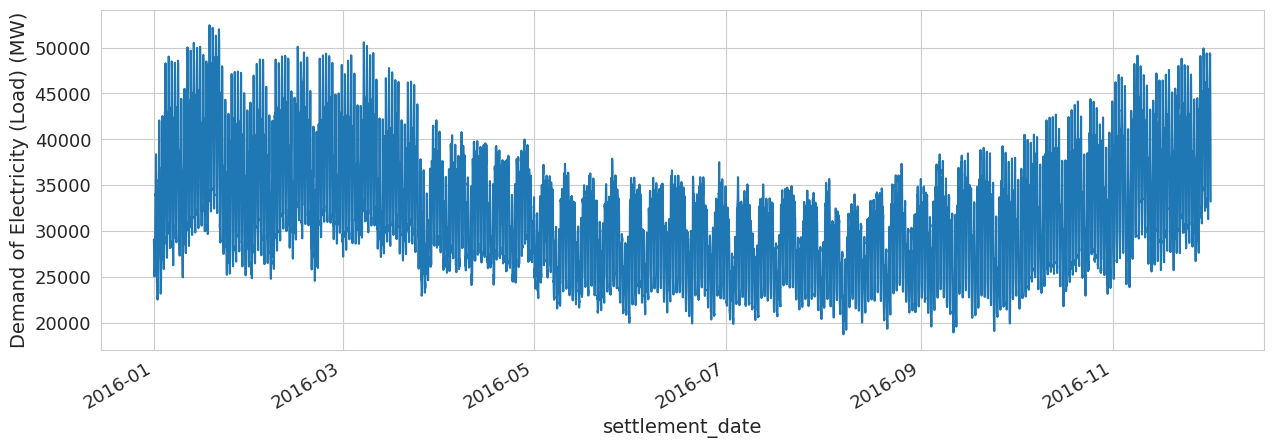

In [30]:
data_frame.loc[(data_frame.index > "01-01-2016") & (data_frame.index < "12-02-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Demand of Electricity (Load) (MW)"
);

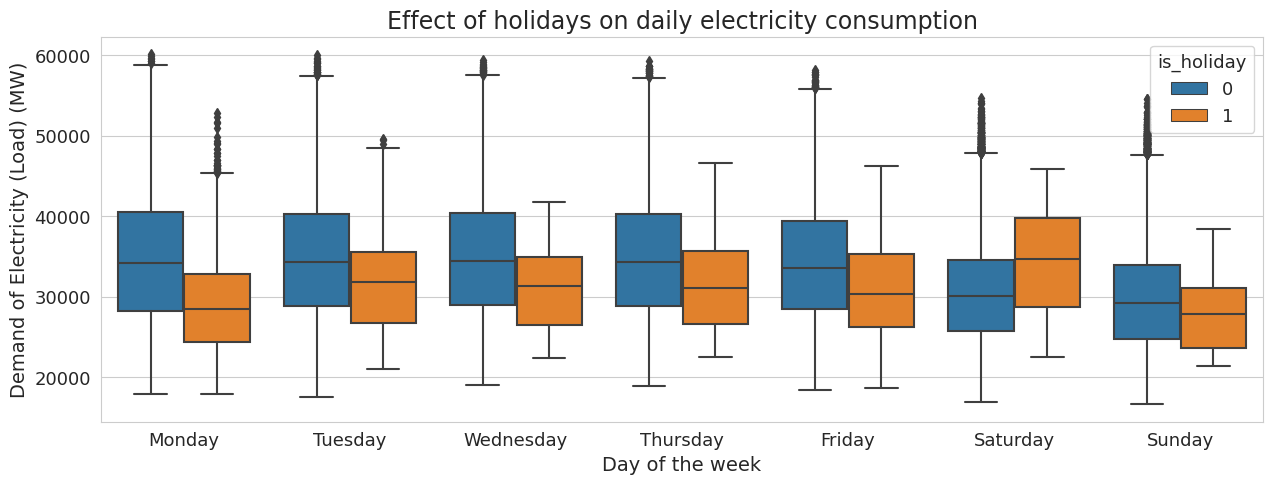

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="day_of_week", y="tsd", data=data_frame, hue="is_holiday", ax=ax)

ax.set_xticklabels(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
ax.set_xlabel("Day of the week")
ax.set_ylabel("Demand of Electricity (Load) (MW)")
ax.set_title("Effect of holidays on daily electricity consumption");

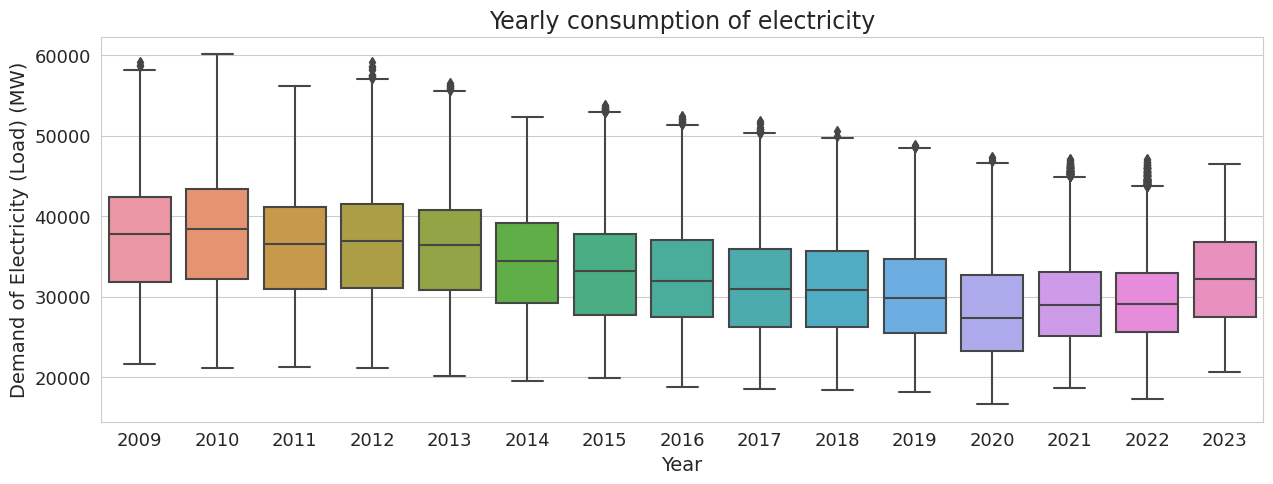

In [32]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="year", y="tsd", data=data_frame)

ax.set_xlabel("Year")
ax.set_ylabel("Demand of Electricity (Load) (MW)")
ax.set_title("Yearly consumption of electricity");

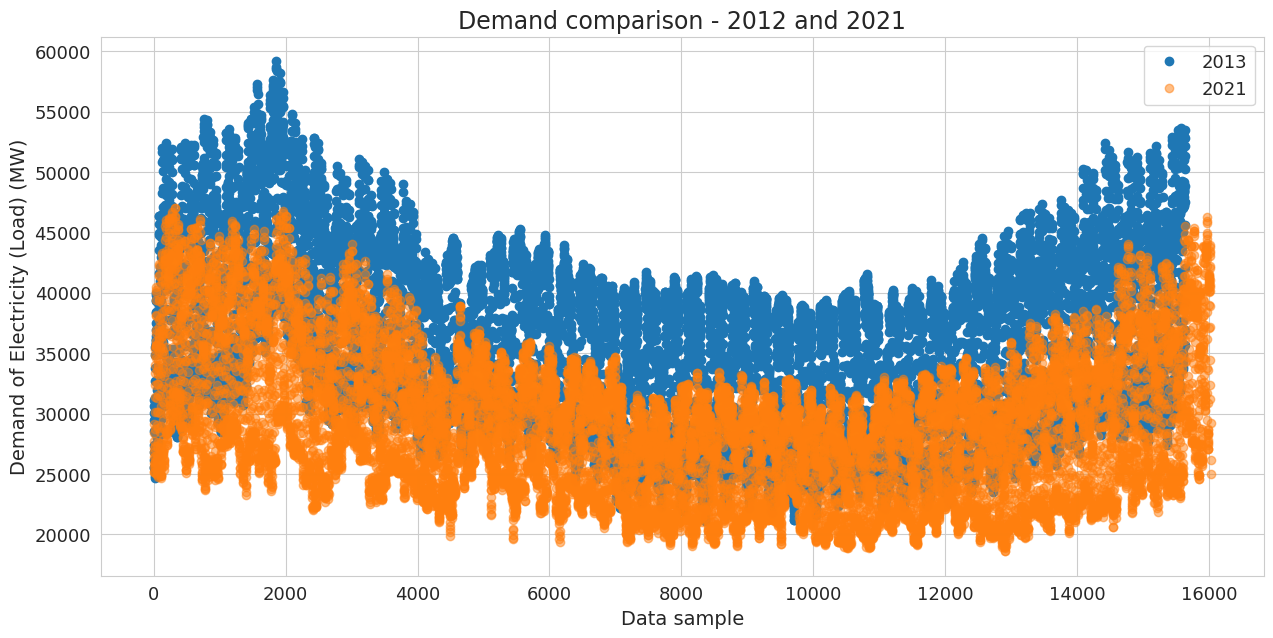

In [33]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(
    range(len(data_frame.loc[(data_frame.index > "01-01-2012") & (data_frame.index < "12-01-2012")]["tsd"])),
    data_frame.loc[(data_frame.index > "01-01-2012") & (data_frame.index < "12-01-2012")]["tsd"],
    "o",
    label="2013",
)

ax.plot(
    range(len(data_frame.loc[(data_frame.index > "01-01-2021") & (data_frame.index < "12-01-2021")]["tsd"])),
    data_frame.loc[(data_frame.index > "01-01-2021") & (data_frame.index < "12-01-2021")]["tsd"],
    "o",
    alpha=0.5,
    label="2021",
)
ax.set_xlabel("Data sample")
ax.set_ylabel("Demand of Electricity (Load) (MW)")
ax.legend(loc="best")
ax.set_title("Demand comparison - 2012 and 2021");

# **Models implementation**

In [34]:
def mean_absolute_percentage_error(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

In [35]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [36]:
threshold_1 = "06-01-2019"
threshold_date_2 = "06-01-2021"
train_data = data_frame.loc[data_frame.index < threshold_1]
test_data = data_frame.loc[(data_frame.index >= threshold_1) & (data_frame.index < threshold_date_2)]
hold_out_data = data_frame.loc[data_frame.index >= threshold_date_2]

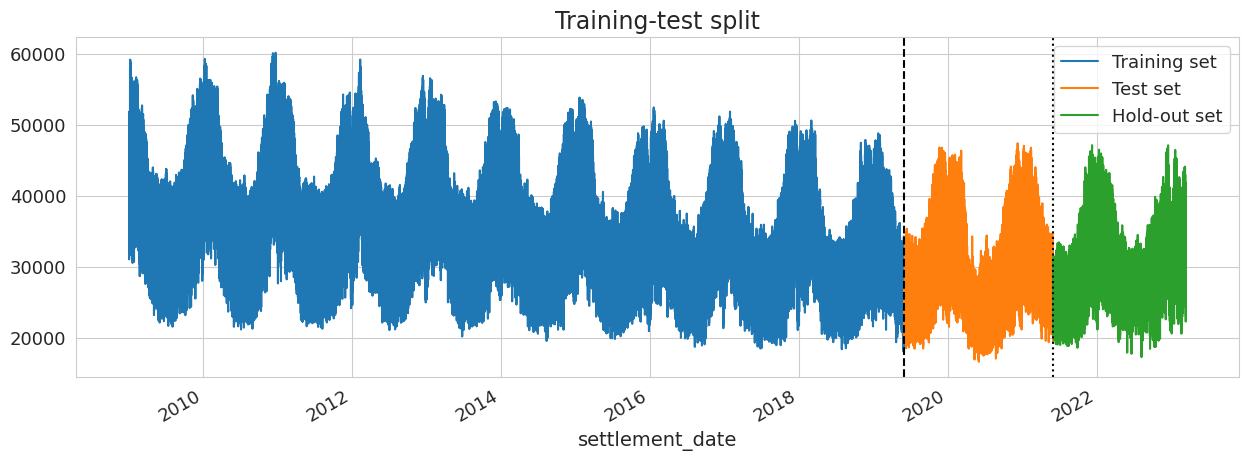

In [37]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data["tsd"].plot(ax=ax, label="Training set")
test_data["tsd"].plot(ax=ax, label="Test set")
hold_out_data["tsd"].plot(ax=ax, label="Hold-out set")
ax.axvline(threshold_1, color="k", ls="--")
ax.axvline(threshold_date_2, color="k", ls=":")
ax.set_title("Training-test split")
plt.legend();

Features extraction and data splitting for the implementation of models

In [41]:
train_data = data_frame.loc[data_frame.index < threshold_1]
test_data = data_frame.loc[(data_frame.index >= threshold_1) & (data_frame.index < threshold_date_2)]
hold_out_data = data_frame.loc[data_frame.index >= threshold_date_2]

# Define the features and target variable
features_extracted = [
    "is_holiday",
    "settlement_period",
    "Month_day",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
]
target = "tsd"

FEATURES_TARGET = features_extracted.copy()
FEATURES_TARGET.append(target)
train_data_keras = train_data[FEATURES_TARGET]
test_data_keras = test_data[FEATURES_TARGET]
results_table = test_data_keras
scaler = MinMaxScaler(feature_range=(0,1))
train_data_keras_s = scaler.fit_transform(train_data_keras.values)
test_data_keras_s = scaler.transform(test_data_keras.values)

X_train = (
    train_data_keras_s[:,:-1].
    reshape(train_data_keras_s.shape[0],1,len(features_extracted))
)
y_train = train_data_keras_s[:,-1]

X_test = (
    test_data_keras_s[:,:-1].
    reshape(test_data_keras_s.shape[0],1,len(features_extracted))
)
y_test = test_data_keras_s[:,-1]


# **LSTM**

In [42]:
# Define a random seed for reproducibility
tf.random.set_seed(221)

# Create and compite neural network
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(Dropout(0.5))
# model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
# model.add(Dropout(0.5))
# model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss = root_mean_squared_error, optimizer="adam")
# Fit model
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=144,
    validation_data=(X_test, y_test)
    
)

Epoch 1/100
1263/1263 [==============================] - 19s 8ms/step - loss: 0.1277 - val_loss: 0.0948
Epoch 2/100
1263/1263 [==============================] - 8s 6ms/step - loss: 0.0982 - val_loss: 0.0875
Epoch 3/100
1263/1263 [==============================] - 9s 7ms/step - loss: 0.0889 - val_loss: 0.0807
Epoch 4/100
1263/1263 [==============================] - 10s 8ms/step - loss: 0.0846 - val_loss: 0.0803
Epoch 5/100
1263/1263 [==============================] - 10s 8ms/step - loss: 0.0816 - val_loss: 0.0736
Epoch 6/100
1263/1263 [==============================] - 8s 7ms/step - loss: 0.0791 - val_loss: 0.0700
Epoch 7/100
1263/1263 [==============================] - 9s 7ms/step - loss: 0.0768 - val_loss: 0.0671
Epoch 8/100
1263/1263 [==============================] - 10s 8ms/step - loss: 0.0734 - val_loss: 0.0642
Epoch 9/100
1263/1263 [==============================] - 9s 7ms/step - loss: 0.0693 - val_loss: 0.0622
Epoch 10/100
1263/1263 [==============================] - 9s 7ms/step

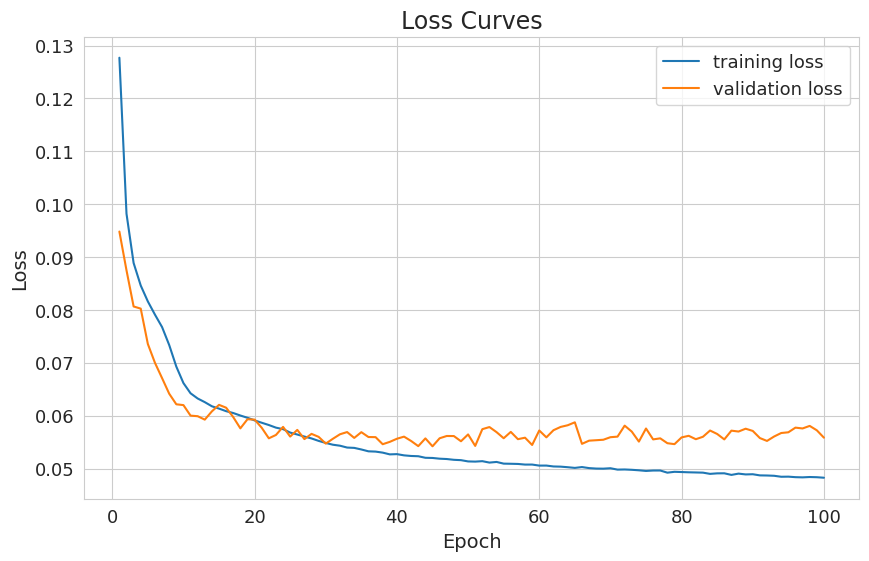

In [43]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(1, len(history.history["loss"]) + 1),
    history.history["loss"],
    label="training loss",
)
ax.plot(
    range(1, len(history.history["loss"]) + 1),
    history.history["val_loss"],
    label="validation loss",
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss Curves")
ax.legend(loc="best");

Once the neiureal network has been trained, we can make predictions on the test set. Remember that we had to scale all the data to fit the mode. thus, we first need to inverse transform the output before we can use for plotting or to calculate the performance with respect to the original electricity demand values.

In [44]:
# Prediction on test set
# results_table = y_test.to_frame()
pred_lstm = model.predict(X_test)

# Inverse transform the prediction
# Since scaler was fit using all the data (9 features + outcome variable)
# we need to store the prediction in the a copy of the original data
results_lstm = test_data_keras_s
results_lstm[:,-1] = pred_lstm.reshape(pred_lstm.shape[0])

results_lstm = scaler.inverse_transform(results_lstm)

# Store inverse transformed preductons in the result dataframe
results_table["pred_lstm"] = results_lstm[:,-1]

1097/1097 [==============================] - 4s 3ms/step


<ipython-input-44-41d1c89b26b4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_table["pred_lstm"] = results_lstm[:,-1]


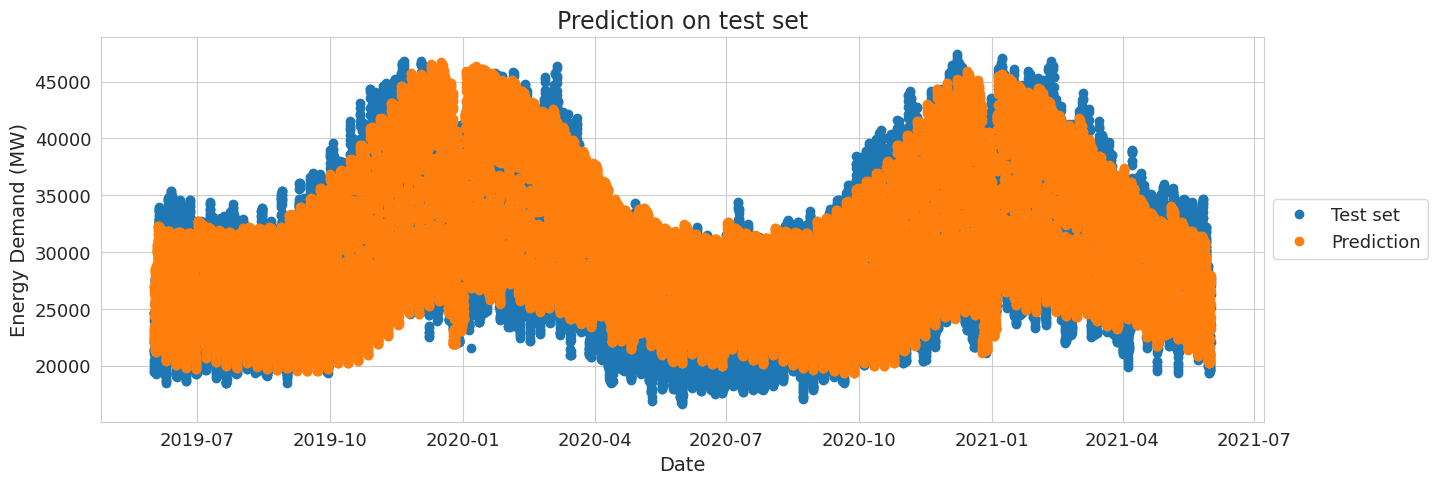

In [45]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(results_table.index, results_table["tsd"], "o", label="Test set")
ax.plot(results_table.index, results_table["pred_lstm"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

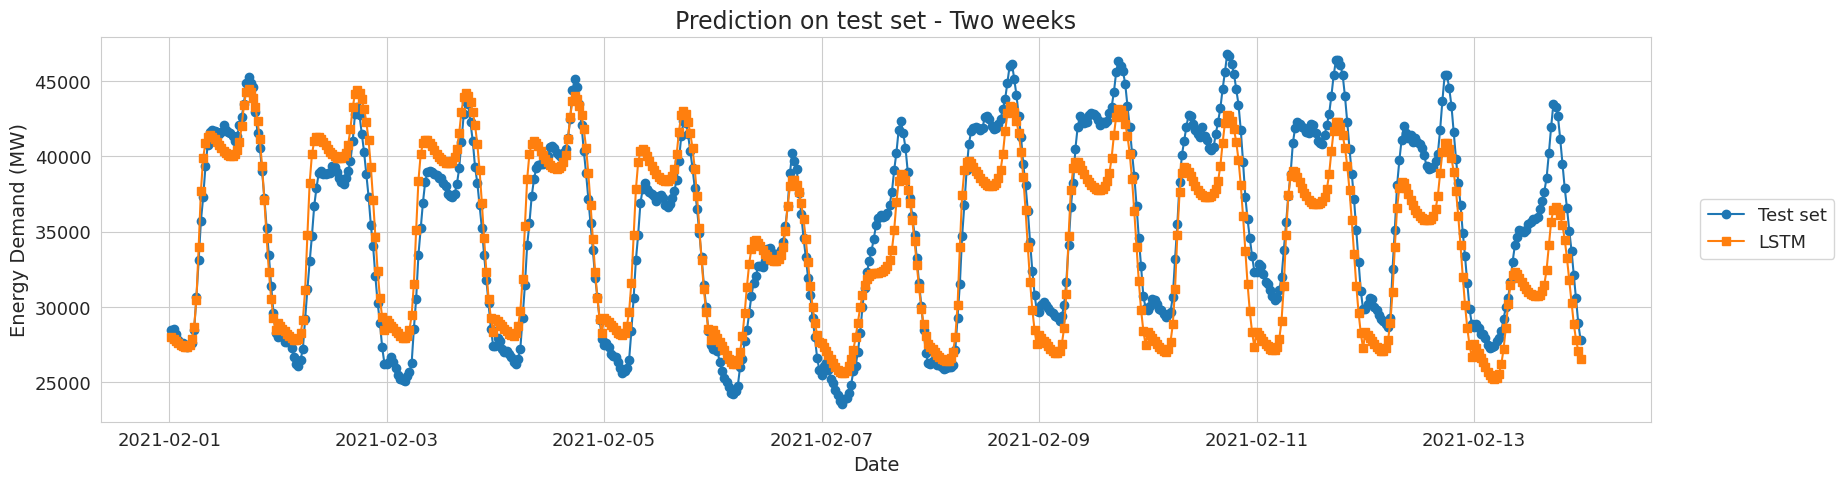

In [46]:
start = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(
    results_table.loc[(results_table.index > start) & (results_table.index < end)].index,
    results_table.loc[(results_table.index > start) & (results_table.index < end)]["tsd"],
    "-o",
    label="Test set",
)

ax.plot(
    results_table.loc[(results_table.index > start) & (results_table.index < end)].index,
    results_table.loc[(results_table.index > start) & (results_table.index < end)][
        "pred_lstm"
    ],
    "-s",
    label="LSTM",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [47]:
mape_lstm = mean_absolute_percentage_error(
    y_test, results_table["pred_lstm"]
)

rmse_lstm = np.sqrt(mean_squared_error(y_test, results_table["pred_lstm"]))

print(
    "Mean Absolute Percentage Error of the LSTM model is: %.2f" % mape_lstm
)

print(
    "Root Mean Squared Error of the LSTM model is: %.2f MW" % rmse_lstm
)

Mean Absolute Percentage Error of the LSTM model is: 13132857.74
Root Mean Squared Error of the LSTM model is: 30351.54 MW


## **CNN-LSTM**

In [48]:
model = Sequential()
model.add(Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(256,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss = root_mean_squared_error, optimizer="adam")

# Fit model
history_deep_lstm = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=144,
    validation_data=(X_test, y_test)
    
)

Epoch 1/100
1263/1263 [==============================] - 20s 8ms/step - loss: 0.1169 - val_loss: 0.0648
Epoch 2/100
1263/1263 [==============================] - 10s 8ms/step - loss: 0.0862 - val_loss: 0.0506
Epoch 3/100
1263/1263 [==============================] - 10s 8ms/step - loss: 0.0802 - val_loss: 0.0417
Epoch 4/100
1263/1263 [==============================] - 10s 8ms/step - loss: 0.0784 - val_loss: 0.0422
Epoch 5/100
1263/1263 [==============================] - 10s 8ms/step - loss: 0.0768 - val_loss: 0.0410
Epoch 6/100
1263/1263 [==============================] - 10s 8ms/step - loss: 0.0759 - val_loss: 0.0462
Epoch 7/100
1263/1263 [==============================] - 10s 8ms/step - loss: 0.0747 - val_loss: 0.0471
Epoch 8/100
1263/1263 [==============================] - 10s 8ms/step - loss: 0.0741 - val_loss: 0.0396
Epoch 9/100
1263/1263 [==============================] - 11s 9ms/step - loss: 0.0734 - val_loss: 0.0454
Epoch 10/100
1263/1263 [==============================] - 10s 8m

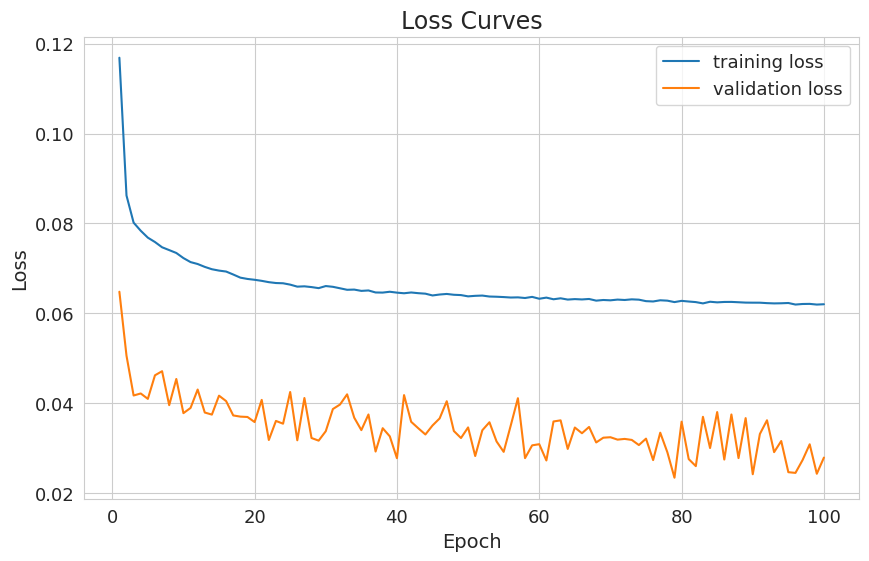

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(1, len(history_deep_lstm.history["loss"]) + 1),
    history_deep_lstm.history["loss"],
    label="training loss",
)
ax.plot(
    range(1, len(history_deep_lstm.history["loss"]) + 1),
    history_deep_lstm.history["val_loss"],
    label="validation loss",
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss Curves")
ax.legend(loc="best");

Similarly to the previous LSTM model, the output needs to inverse transformed.

In [50]:
# Prediction on test set
pred_deep_lstm = model.predict(X_test)

# Inverse transform the prediction
# Since scaler was fit using all the data (9 features + outcome variable)
# we need to store the prediction in the a copy of the original data
results_deep_lstm = test_data_keras_s
results_deep_lstm[:,-1] = pred_deep_lstm.reshape(pred_deep_lstm.shape[0])
results_deep_lstm = scaler.inverse_transform(results_deep_lstm)

# Store inverse transformed preductons in the result dataframe
results_table["pred_deep_lstm"] = results_deep_lstm[:,-1]

1097/1097 [==============================] - 5s 4ms/step


<ipython-input-50-c6fd0b67de1b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_table["pred_deep_lstm"] = results_deep_lstm[:,-1]


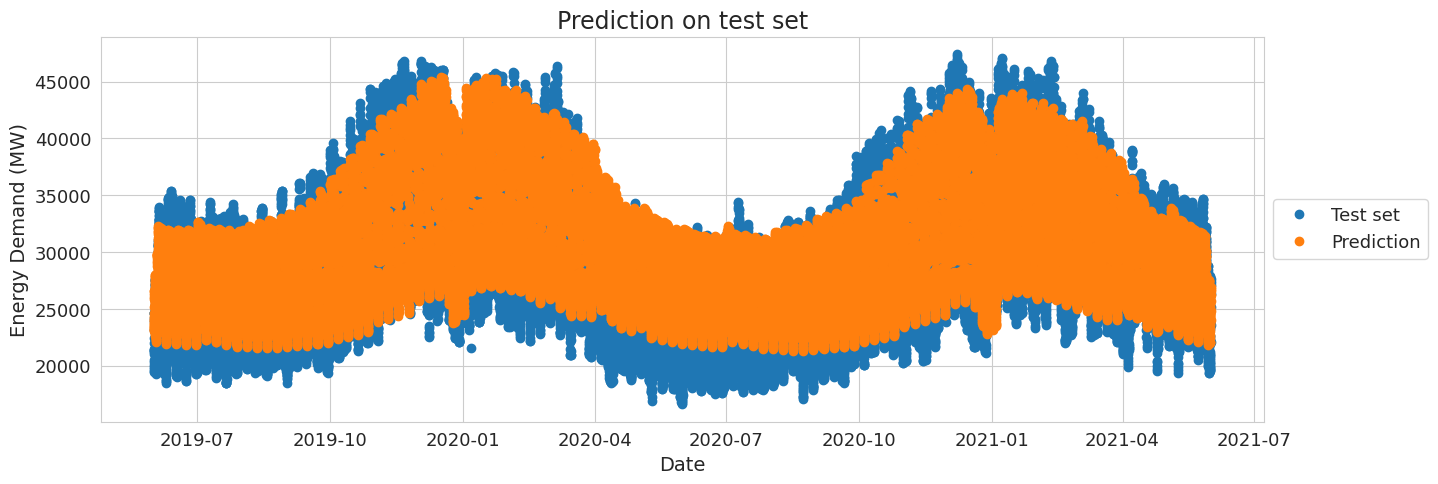

In [51]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(results_table.index, results_table["tsd"], "o", label="Test set")
ax.plot(results_table.index, results_table["pred_deep_lstm"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

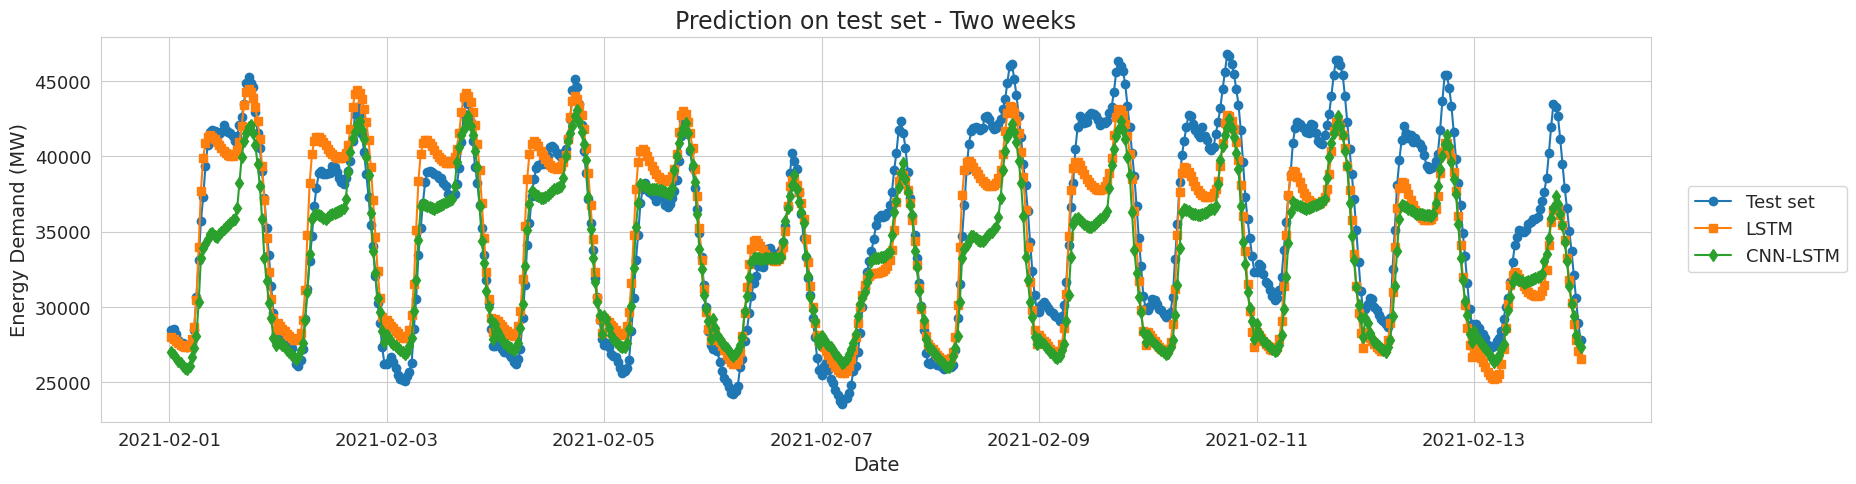

In [52]:
start = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(
    results_table.loc[(results_table.index > start) & (results_table.index < end)].index,
    results_table.loc[(results_table.index > start) & (results_table.index < end)]["tsd"],
    "-o",
    label="Test set",
)

ax.plot(
    results_table.loc[(results_table.index > start) & (results_table.index < end)].index,
    results_table.loc[(results_table.index > start) & (results_table.index < end)][
        "pred_lstm"
    ],
    "-s",
    label="LSTM",
)

ax.plot(
    results_table.loc[(results_table.index > start) & (results_table.index < end)].index,
    results_table.loc[(results_table.index > start) & (results_table.index < end)][
        "pred_deep_lstm"
    ],
    "-d",
    label="CNN-LSTM",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [53]:
mape_deep_lstm = mean_absolute_percentage_error(
    y_test, results_table["pred_deep_lstm"]
)

rmse_deep_lstm = np.sqrt(mean_squared_error(y_test, results_table["pred_deep_lstm"]))

print(
    "Mean Absolute Percentage Error of the CNN-LSTM model is: %.2f" % mape_deep_lstm
)

print(
    "Root Mean Squared Error of the CNN-LSTM model is: %.2f MW" % rmse_deep_lstm
)

Mean Absolute Percentage Error of the CNN-LSTM model is: 11980342.66
Root Mean Squared Error of the CNN-LSTM model is: 30252.39 MW


# **Quantile LSTM**



In [54]:
from keras.layers import Concatenate
from keras.models import Model
from keras.layers import Input

# Define quantile levels
quantiles = [0.1, 0.5, 0.9]

# Define quantile loss function
def quantile_loss(q, y, f):
    e = (y - f)
    return K.mean(K.maximum(q * e, (q - 1) * e), axis=-1)

# Define input shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Define input layer
inputs = Input(shape=input_shape)


# Define LSTM layers
lstm1 = LSTM(256, return_sequences=True)(inputs)
drop1 = Dropout(0.5)(lstm1)
lstm2 = LSTM(128, return_sequences=True)(drop1)
drop2 = Dropout(0.5)(lstm2)
lstm3 = LSTM(32)(drop2)
drop3 = Dropout(0.5)(lstm3)
   
outputs = [Dense(1)(drop3) for _ in quantiles]

# Define model
model = Model(inputs=inputs, outputs=outputs)

# Define quantile metrics
metrics = []
for q in quantiles:
    def q_loss(y_true, y_pred):
        return quantile_loss(q, y_true, y_pred)
    q_loss.__name__ = f"q_{q}"
    metrics.append(q_loss)

model.compile(loss=metrics, optimizer="adam")

history_quantile_lstm = model.fit(
    X_train,
    [y_train]*len(quantiles),
    epochs=100,
    batch_size=144,
    validation_data=(X_test, [y_test]*len(quantiles))
    
)


Epoch 1/100
1263/1263 [==============================] - 23s 13ms/step - loss: 0.1106 - dense_4_loss: 0.0387 - dense_5_loss: 0.0360 - dense_6_loss: 0.0359 - val_loss: 0.0457 - val_dense_4_loss: 0.0156 - val_dense_5_loss: 0.0150 - val_dense_6_loss: 0.0151
Epoch 2/100
1263/1263 [==============================] - 15s 12ms/step - loss: 0.0591 - dense_4_loss: 0.0200 - dense_5_loss: 0.0196 - dense_6_loss: 0.0195 - val_loss: 0.0419 - val_dense_4_loss: 0.0141 - val_dense_5_loss: 0.0139 - val_dense_6_loss: 0.0139
Epoch 3/100
1263/1263 [==============================] - 15s 12ms/step - loss: 0.0515 - dense_4_loss: 0.0173 - dense_5_loss: 0.0171 - dense_6_loss: 0.0171 - val_loss: 0.0413 - val_dense_4_loss: 0.0138 - val_dense_5_loss: 0.0138 - val_dense_6_loss: 0.0137
Epoch 4/100
1263/1263 [==============================] - 16s 13ms/step - loss: 0.0490 - dense_4_loss: 0.0163 - dense_5_loss: 0.0163 - dense_6_loss: 0.0163 - val_loss: 0.0401 - val_dense_4_loss: 0.0135 - val_dense_5_loss: 0.0133 - val_d

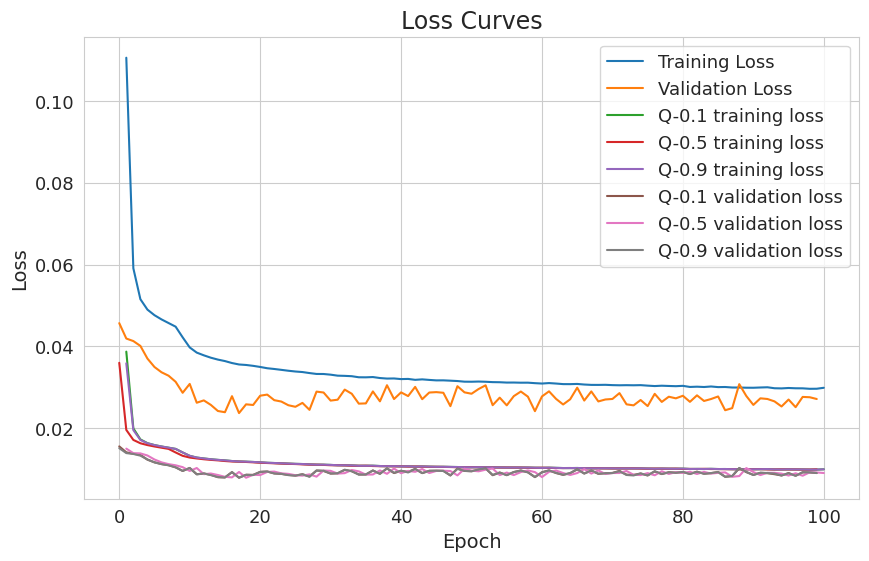

In [55]:
fig, ax = plt.subplots(figsize=(10, 6),dpi=100)
ax.plot(
    range(1, len(history_quantile_lstm.history["loss"]) + 1),
    history_quantile_lstm.history["loss"],history_quantile_lstm.history["val_loss"],

)

ax.plot(
    range(1, len(history_quantile_lstm.history["val_loss"]) + 1),
    history_quantile_lstm.history["dense_4_loss"],history_quantile_lstm.history["dense_5_loss"],

)
ax.plot(
    range(1, len(history_quantile_lstm.history["val_loss"]) + 1),
    history_quantile_lstm.history["dense_6_loss"],history_quantile_lstm.history["val_dense_4_loss"],

)
ax.plot(
    range(1, len(history_quantile_lstm.history["val_loss"]) + 1),
    history_quantile_lstm.history["val_dense_5_loss"],history_quantile_lstm.history["val_dense_6_loss"],

)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss Curves")
ax.legend(loc="best",labels=["Training Loss", "Validation Loss","Q-0.1 training loss", "Q-0.5 training loss", "Q-0.9 training loss","Q-0.1 validation loss","Q-0.5 validation loss","Q-0.9 validation loss"])


In [56]:
quantile_deep_lstm = model.predict(X_test)
quantile_deep_lstm=np.array(quantile_deep_lstm)
quantile_deep_lstm=quantile_deep_lstm[0]
# Inverse transform the prediction
# Since scaler was fit using all the data (9 features + outcome variable)
# we need to store the prediction in the a copy of the original data
results_deep_lstm = test_data_keras_s
results_deep_lstm[:,-1] = quantile_deep_lstm.reshape(quantile_deep_lstm.shape[0])
results_deep_lstm = scaler.inverse_transform(results_deep_lstm)

# Store inverse transformed preductons in the result dataframe
results_table["quant_deep_lstm"] = results_deep_lstm[:,-1]

1097/1097 [==============================] - 5s 4ms/step


<ipython-input-56-d64fb797ddb4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_table["quant_deep_lstm"] = results_deep_lstm[:,-1]


In [57]:
quantile_deep_lstm_1 = model.predict(X_test)
quantile_deep_lstm_1=np.array(quantile_deep_lstm_1)
quantile_deep_lstm_1=quantile_deep_lstm_1[1]
# Inverse transform the prediction
# Since scaler was fit using all the data (9 features + outcome variable)
# we need to store the prediction in the a copy of the original data
results_deep_lstm_1 = test_data_keras_s
results_deep_lstm_1[:,-1] = quantile_deep_lstm_1.reshape(quantile_deep_lstm_1.shape[0])
results_deep_lstm_1 = scaler.inverse_transform(results_deep_lstm_1)

# Store inverse transformed preductons in the result dataframe
results_table["quant_deep_lstm_1"] = results_deep_lstm_1[:,-1]

1097/1097 [==============================] - 4s 3ms/step


<ipython-input-57-7851104680ae>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_table["quant_deep_lstm_1"] = results_deep_lstm_1[:,-1]


In [58]:
quantile_deep_lstm_2 = model.predict(X_test)
quantile_deep_lstm_2=np.array(quantile_deep_lstm_2)
quantile_deep_lstm_2=quantile_deep_lstm_2[2]
# Inverse transform the prediction
# Since scaler was fit using all the data (9 features + outcome variable)
# we need to store the prediction in the a copy of the original data
results_deep_lstm_2 = test_data_keras_s
results_deep_lstm_2[:,-1] = quantile_deep_lstm_2.reshape(quantile_deep_lstm_2.shape[0])
results_deep_lstm_2 = scaler.inverse_transform(results_deep_lstm_2)

# Store inverse transformed preductons in the result dataframe
results_table["quant_deep_lstm_2"] = results_deep_lstm_2[:,-1]

1097/1097 [==============================] - 4s 3ms/step


<ipython-input-58-a220027b741f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_table["quant_deep_lstm_2"] = results_deep_lstm_2[:,-1]


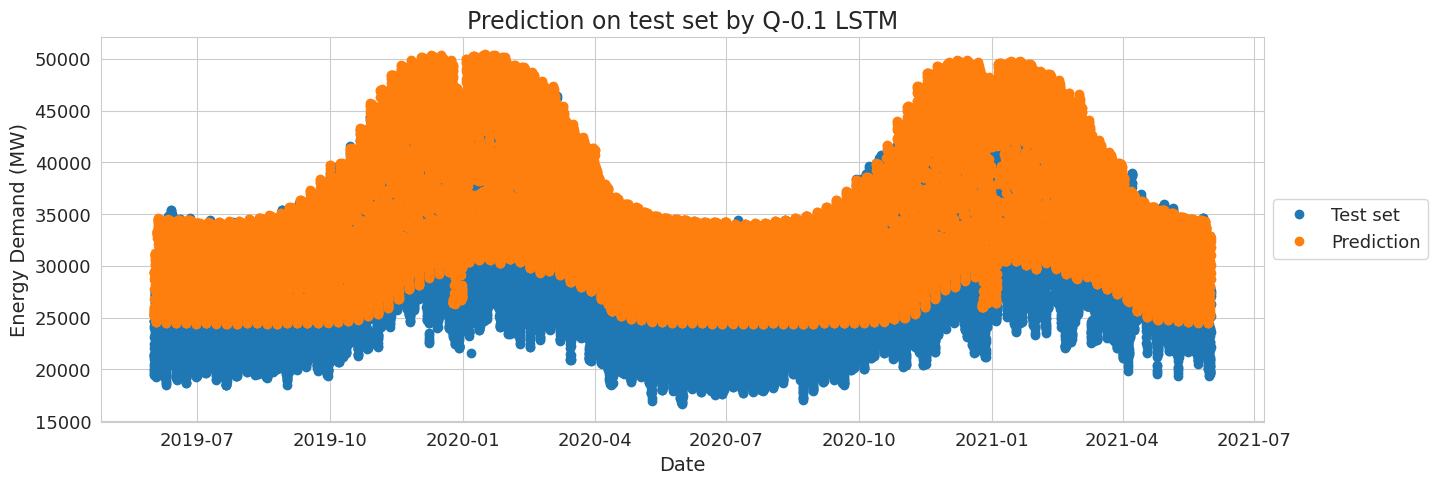

In [59]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(results_table.index, results_table["tsd"], "o", label="Test set")
ax.plot(results_table.index, results_table["quant_deep_lstm"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set by Q-0.1 LSTM")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

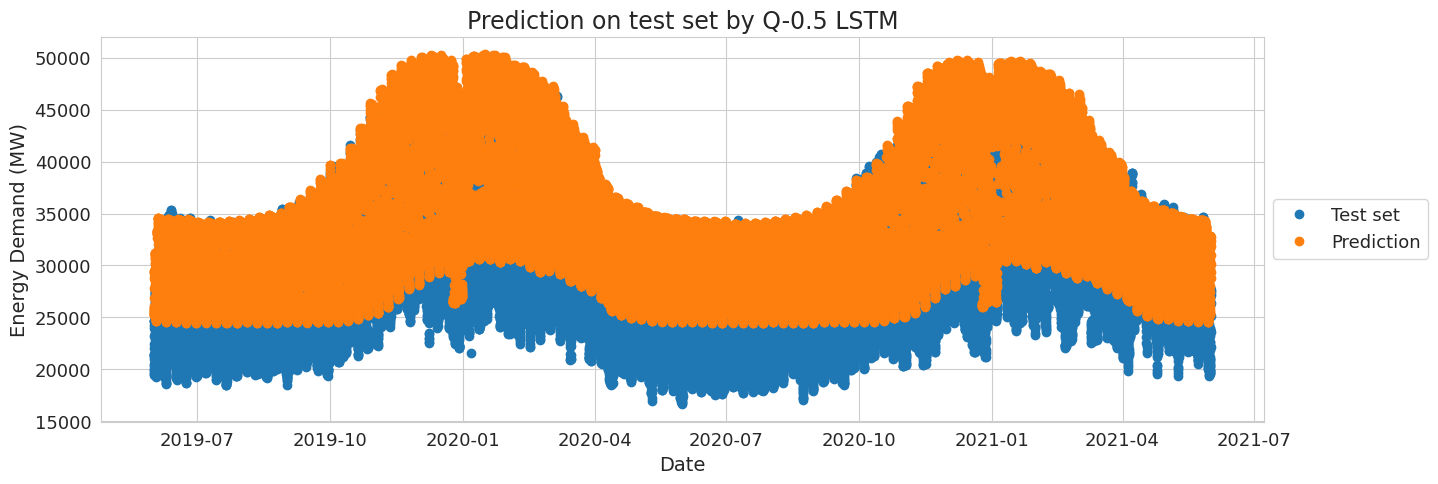

In [60]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(results_table.index, results_table["tsd"], "o", label="Test set")
ax.plot(results_table.index, results_table["quant_deep_lstm_1"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set by Q-0.5 LSTM")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

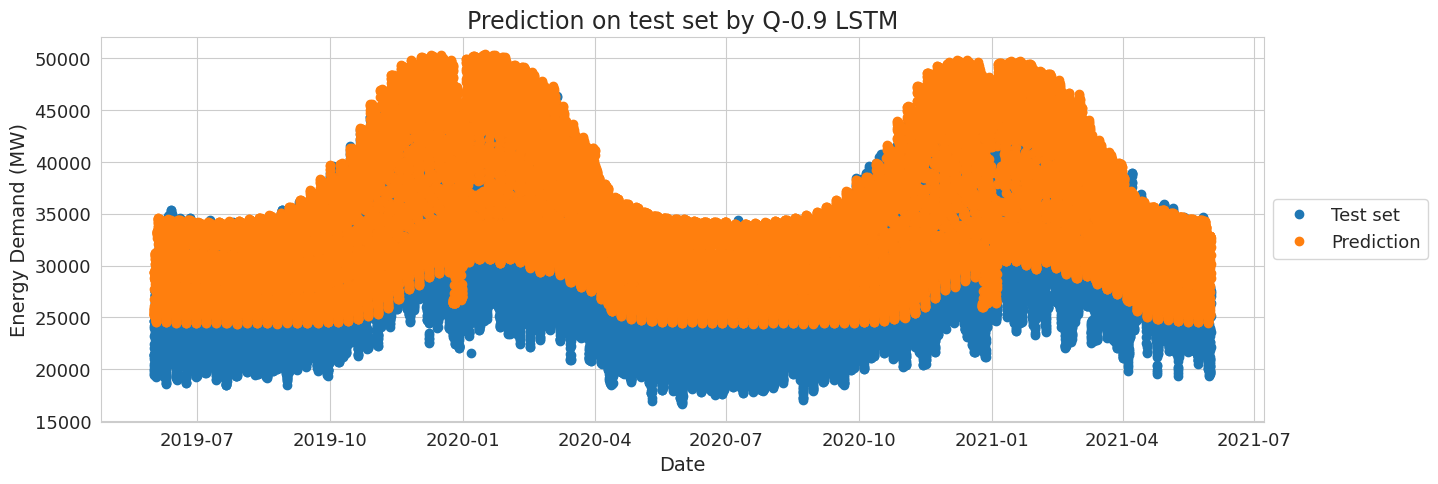

In [61]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(results_table.index, results_table["tsd"], "o", label="Test set")
ax.plot(results_table.index, results_table["quant_deep_lstm_2"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set by Q-0.9 LSTM")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

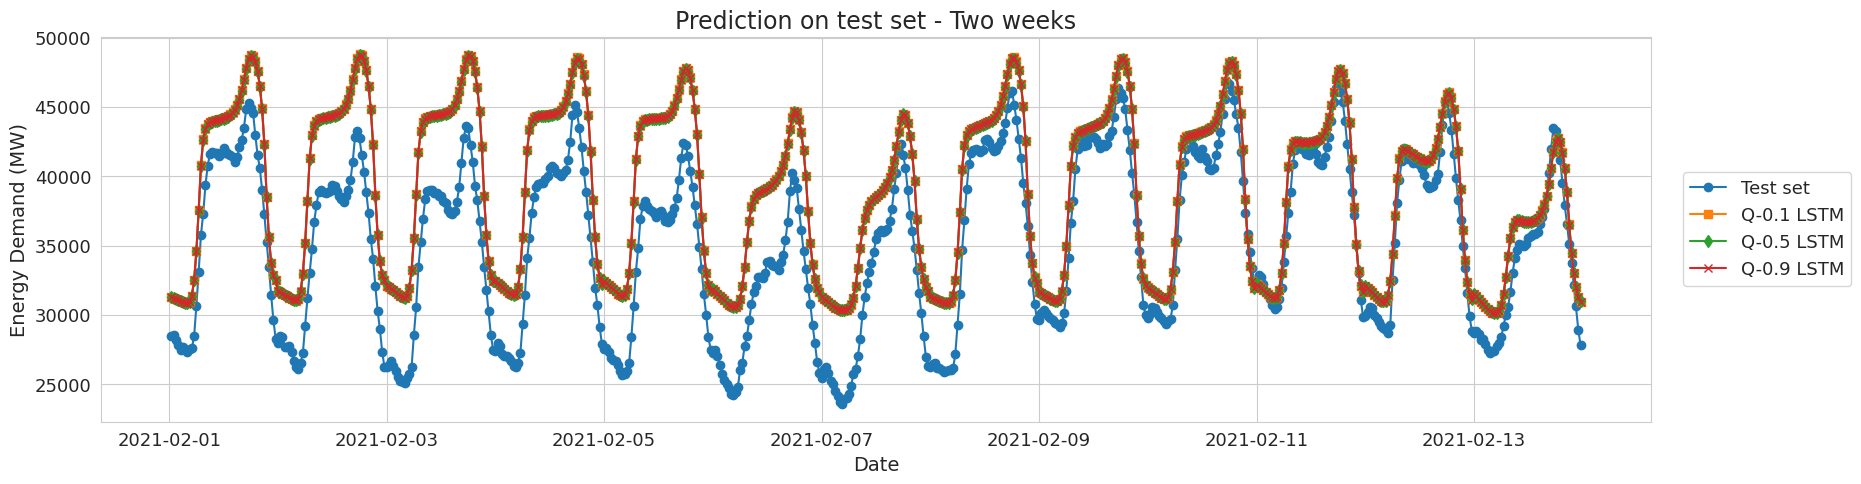

In [62]:
start = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(
    results_table.loc[(results_table.index > start) & (results_table.index < end)].index,
    results_table.loc[(results_table.index > start) & (results_table.index < end)]["tsd"],
    "-o",
    label="Test set",
)

ax.plot(
    results_table.loc[(results_table.index > start) & (results_table.index < end)].index,
    results_table.loc[(results_table.index > start) & (results_table.index < end)][
        "quant_deep_lstm"
    ],
    "-s",
    label="Q-0.1 LSTM",
)

ax.plot(
    results_table.loc[(results_table.index > start) & (results_table.index < end)].index,
    results_table.loc[(results_table.index > start) & (results_table.index < end)][
        "quant_deep_lstm_1"
    ],
    "-d",
    label="Q-0.5 LSTM",
)

ax.plot(
    results_table.loc[(results_table.index > start) & (results_table.index < end)].index,
    results_table.loc[(results_table.index > start) & (results_table.index < end)][
        "quant_deep_lstm_2"
    ],
    "-x",
    label="Q-0.9 LSTM",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [63]:
mape_deep_lstm_1 = mean_absolute_percentage_error(
    y_test, results_table["quant_deep_lstm"]
)

rmse_deep_lstm_1 = np.sqrt(mean_squared_error(y_test, results_table["quant_deep_lstm"]))

print(
    "Mean Absolute Percentage Error of the LSTM Q-0.1 model is: %.2f" % mape_deep_lstm_1
)

print(
    "Root Mean Squared Error of the LSTM Q-0.1 model is: %.2f MW" % rmse_deep_lstm_1
)

Mean Absolute Percentage Error of the LSTM Q-0.1 model is: 9931470.32
Root Mean Squared Error of the LSTM Q-0.1 model is: 34179.72 MW


In [64]:
mape_deep_lstm_2 = mean_absolute_percentage_error(
    y_test, results_table["quant_deep_lstm_1"]
)

rmse_deep_lstm_2 = np.sqrt(mean_squared_error(y_test, results_table["quant_deep_lstm_1"]))

print(
    "Mean Absolute Percentage Error of the LSTM Q-0.5 model is: %.2f" % mape_deep_lstm_2)

print(
    "Root Mean Squared Error of the LSTM Q-0.5 model is: %.2f MW" % rmse_deep_lstm_2
)

Mean Absolute Percentage Error of the LSTM Q-0.5 model is: 9935958.47
Root Mean Squared Error of the LSTM Q-0.5 model is: 34173.58 MW


In [65]:
mape_deep_lstm_3 = mean_absolute_percentage_error(
    y_test, results_table["quant_deep_lstm_2"]
)

rmse_deep_lstm_3 = np.sqrt(mean_squared_error(y_test, results_table["quant_deep_lstm_2"]))

print(
    "Mean Absolute Percentage Error of the LSTM Q-0.9 model is: %.2f" % mape_deep_lstm_3
)

print(
    "Root Mean Squared Error of the LSTM Q-0.9 model is: %.2f MW" % rmse_deep_lstm_3
)

Mean Absolute Percentage Error of the LSTM Q-0.9 model is: 9933710.75
Root Mean Squared Error of the LSTM Q-0.9 model is: 34178.69 MW


In [66]:
summary_data_frame = pd.DataFrame(
    {
        
        "LSTM": [mape_lstm, rmse_lstm],
        "CNN-LSTM": [mape_deep_lstm, rmse_deep_lstm],
        "Quantile LSTM (0.1)": [mape_deep_lstm_1, rmse_deep_lstm_1],
        "Quantile LSTM (0.5)": [mape_deep_lstm_2, rmse_deep_lstm_2],
        "Quantile LSTM (0.9)": [mape_deep_lstm_3, rmse_deep_lstm_3],
        "Metric": ["MAPE", "RMSE"]
    }
)

summary_data_frame.set_index("Metric", inplace=True)

summary_data_frame.style.format('{:.2f}') 

,LSTM,CNN-LSTM,Quantile LSTM (0.1),Quantile LSTM (0.5),Quantile LSTM (0.9)
Metric,,,,,
MAPE,13132857.74,11980342.66,9931470.32,9935958.47,9933710.75
RMSE,30351.54,30252.39,34179.72,34173.58,34178.69
